# OS-MNIST Visualization

## 1. Generate Data

In [115]:
import os
os.system("python3 build_os-mnist.py --testrun")
#os.system("python3 build_os-mnist.py --testrun --fashion")
#os.system("python3 build_os-mnist.py --testrun --kuzushiji")

0

## 2. Load Data

load standard libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

get tf-record parser

In [2]:
def _multimnist_parse_osmnist(example_proto):
    features = {
        "image_left": tf.FixedLenFeature([], tf.string),
        "image_right": tf.FixedLenFeature([], tf.string),
        "label1": tf.FixedLenFeature([], tf.int64),
        "label2": tf.FixedLenFeature([], tf.int64),
        "label3": tf.FixedLenFeature([], tf.int64),
        "occlusion_left": tf.FixedLenFeature([], tf.float32),
        "occlusion_right": tf.FixedLenFeature([], tf.float32),
        "occlusion_avg": tf.FixedLenFeature([], tf.float32),
        "segmap_left": tf.FixedLenFeature([], tf.string),
        "segmap_right": tf.FixedLenFeature([], tf.string),
      }
        

    parsed_features = tf.parse_single_example(example_proto, features)
    
    no_classes = 10
    one_hot = tf.one_hot(parsed_features["label1"], no_classes)
    
    occ1_one_hot = tf.one_hot(parsed_features["label2"], no_classes)
    occ2_one_hot = tf.one_hot(parsed_features["label3"], no_classes)
    n_hot = one_hot + occ1_one_hot + occ2_one_hot

    images_encoded_l =  parsed_features["image_left"]
    images_encoded_r =  parsed_features["image_right"]

    image_decoded_l = tf.image.decode_png(images_encoded_l)
    image_decoded_r = tf.image.decode_png(images_encoded_r)
    
    segmaps_encoded_l =  parsed_features["segmap_left"]
    segmaps_encoded_r =  parsed_features["segmap_right"]

    segmap_decoded_l = tf.image.decode_png(segmaps_encoded_l)
    segmap_decoded_r = tf.image.decode_png(segmaps_encoded_r)

    return image_decoded_l, image_decoded_r, segmap_decoded_l,\
        segmap_decoded_r, n_hot, one_hot, parsed_features["occlusion_left"], parsed_features["occlusion_avg"]


use parser to get to data

In [3]:
#ds = tf.data.TFRecordDataset('tfrecord_files/2occ/test/osmnist_test0.tfrecord')
#ds = tf.data.TFRecordDataset('osfashionmnist/tfrecord_files/2occ/test/osfashionmnist_test0.tfrecord')
ds = tf.data.TFRecordDataset('oskuzushijimnist/tfrecord_files/2occ/test/oskuzushijimnist_test0.tfrecord')


ds = ds.map(_multimnist_parse_osmnist)
ds = ds.batch(100, drop_remainder=True)
iterator = ds.make_initializable_iterator()

W1101 10:57:10.449079 4406293952 deprecation.py:323] From <ipython-input-3-a6d4738754b5>:8: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [ ]:
sess = tf.Session()
sess.run(iterator.initializer)

## 3. Visualize Data

loop through data and use matplotlib to show its contents

In [4]:
next_step = iterator.get_next()
print(len(next_step))

8


In [8]:
batch = sess.run(iterator.get_next())
left_im = batch[0][0, :, :, 0]
right_im = batch[1][0, :, :, 0]
left_segmap = batch[2][0]
left_bin_segmap = batch[2][0, :, :, 0]
left_bin_segmap = left_bin_segmap > 0
left_bin_segmap = np.asarray(left_bin_segmap, dtype=int)
right_segmap = batch[3][0]
right_bin_segmap = batch[3][0, :, :, 0]
right_bin_segmap = right_bin_segmap > 0
right_bin_segmap = np.asarray(right_bin_segmap, dtype=int)
occlusion_left = batch[-2]
occlusion_avg = batch[-1]

In [19]:
batch[2].shape

(100, 32, 32, 3)

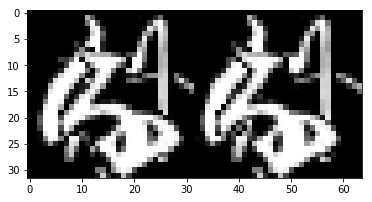

In [20]:
plt.imshow(np.concatenate([left_im, right_im], axis=1), cmap='gray')

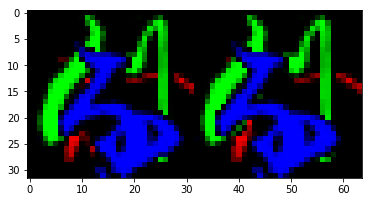

In [21]:
plt.imshow(np.concatenate([left_segmap, right_segmap], axis=1))

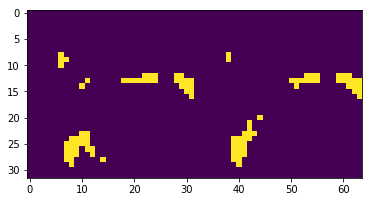

In [22]:
plt.imshow(np.concatenate([left_bin_segmap, right_bin_segmap], axis=1))

avg occlusion: [0.7109827  0.5271318  0.595092   0.5069061  0.47008547 0.4319728
 0.44230768 0.34571427 0.608365   0.54373175 0.46103895 0.6266376
 0.6363636  0.718638   0.6707317  0.7575     0.71243525 0.56550217
 0.43452382 0.62077296 0.51666665 0.6695652  0.38741723 0.30317461
 0.26704547 0.46638656 0.41428572 0.76844263 0.39269406 0.4984985
 0.39341694 0.6086956  0.38343558 0.66793895 0.6459144  0.6262136
 0.5584192  0.51594204 0.37842464 0.519084   0.41221374 0.54
 0.59540635 0.5952381  0.5714286  0.68849206 0.61705685 0.6079295
 0.37407407 0.56856185 0.366426   0.5246637  0.6458333  0.61933535
 0.4864865  0.6395939  0.62285715 0.42326733 0.79555553 0.67096776
 0.5590062  0.4030837  0.6051136  0.6028369  0.5775     0.78
 0.66260165 0.5673077  0.31724137 0.48536587 0.32269505 0.5686275
 0.72953737 0.52394366 0.6757576  0.42941177 0.5258856  0.65789473
 0.6208791  0.4421365  0.58232933 0.34375    0.63904494 0.5303738
 0.51892745 0.44458762 0.5644654  0.5776699  0.41935483 0.7601351


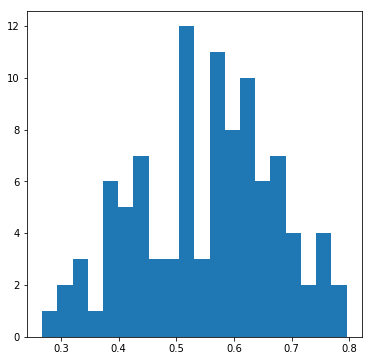

In [23]:
print('avg occlusion: {}'.format(occlusion_avg))
plt.hist(occlusion_avg, bins=20)
plt.show()

In [24]:
# plt.imshow(left_im - right_im)

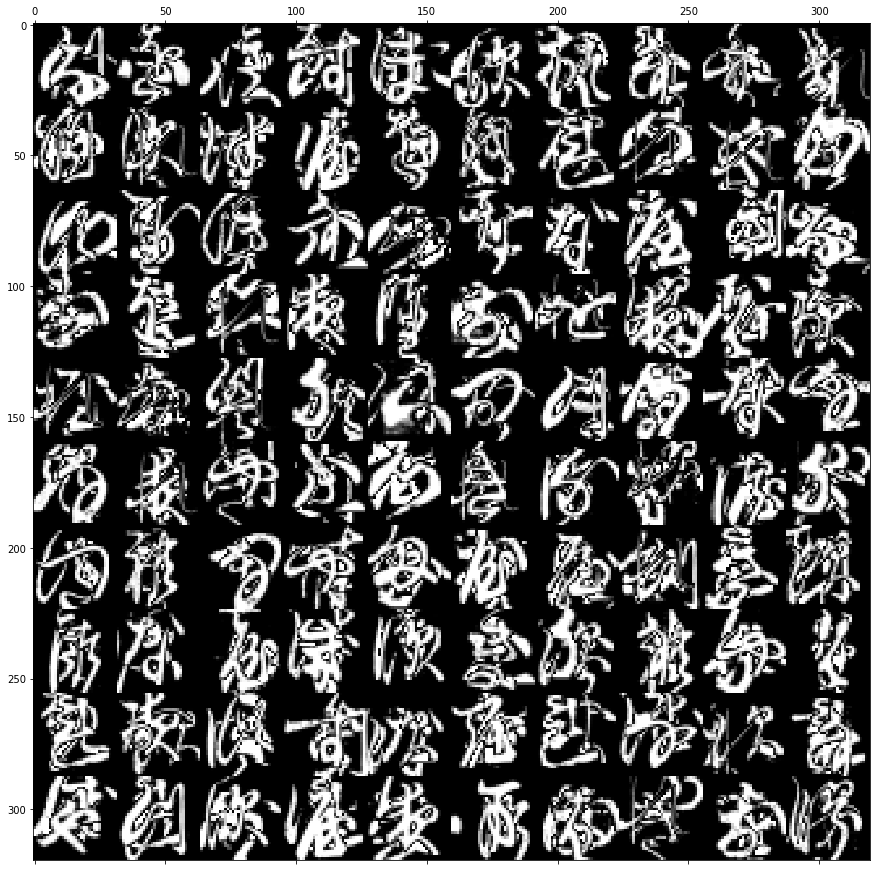

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 15]
plt.matshow(np.concatenate(
    [np.reshape(batch[0][0:10], [320,32]),
     np.reshape(batch[0][10:20], [320,32]),
     np.reshape(batch[0][20:30], [320,32]),
     np.reshape(batch[0][30:40], [320,32]),
     np.reshape(batch[0][40:50], [320,32]),
     np.reshape(batch[0][50:60], [320,32]),
     np.reshape(batch[0][60:70], [320,32]),
     np.reshape(batch[0][70:80], [320,32]),
     np.reshape(batch[0][80:90], [320,32]),
     np.reshape(batch[0][90:100], [320,32])
    ], axis=1), cmap='gray')
mpl.rcParams['figure.figsize'] = [6, 6]

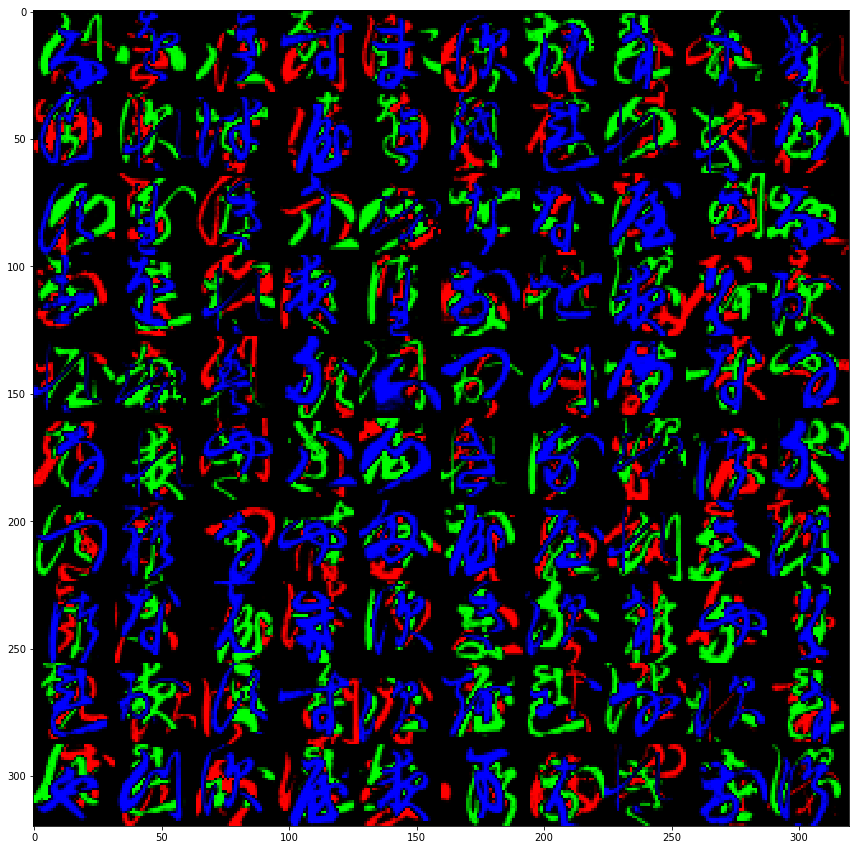

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 15]
plt.imshow(np.concatenate(
    [np.reshape(batch[2][0:10], [320,32,3]),
     np.reshape(batch[2][10:20], [320,32,3]),
     np.reshape(batch[2][20:30], [320,32,3]),
     np.reshape(batch[2][30:40], [320,32,3]),
     np.reshape(batch[2][40:50], [320,32,3]),
     np.reshape(batch[2][50:60], [320,32,3]),
     np.reshape(batch[2][60:70], [320,32,3]),
     np.reshape(batch[2][70:80], [320,32,3]),
     np.reshape(batch[2][80:90], [320,32,3]),
     np.reshape(batch[2][90:100], [320,32,3])
    ], axis=1))
mpl.rcParams['figure.figsize'] = [6, 6]